In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd

In [2]:
class Network(nn.Module):
    def __init__(self, p1, p2, p3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(31, 70, bias= True),
            nn.ReLU(),
            nn.Linear(70, 70, bias= True),
            nn.ReLU(),
            nn.BatchNorm1d(70),
            nn.Dropout(p = p1),
            nn.Linear(70, 65, bias = True),
            nn.ReLU(),
            nn.Linear(65, 60, bias= True),
            nn.ReLU(),
            nn.Linear(60, 60, bias= True),
            nn.ReLU(),
            nn.BatchNorm1d(60),
            nn.Dropout(p= p2),
            nn.Linear(60, 55, bias= True),
            nn.ReLU(),
            nn.Linear(55, 50, bias= True),
            nn.ReLU(),
            nn.Linear(50, 45, bias= True),
            nn.ReLU(),
            nn.BatchNorm1d(45),
            nn.Dropout(p= p3),
            nn.Linear(45, 40, bias= True),
            nn.ReLU(),
            nn.Linear(40, 35, bias = True),
            nn.ReLU(),
            nn.Linear(35, 25, bias = True),
            nn.ReLU(),
            nn.Linear(25, 20, bias = True),
            nn.ReLU(),
            nn.Linear(20, 15, bias = True),
            nn.ReLU(),
            nn.Linear(15, 10, bias = True),
            nn.ReLU(),
            nn.Linear(10, 5, bias = True)
        )
        self.classify = nn.Sequential(
            nn.Linear(5, 1, bias= True),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.classify(self.features(x))

In [3]:
class Data(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = torch.tensor(x.values, dtype= torch.float32)
        self.y = torch.tensor(y.values, dtype= torch.float32)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, index):
        x, y = self.x[index], self.y[index]
        return x, y

In [4]:
xtrain, ytrain, xtest, ytest = pd.read_csv('./X_train.csv', header= None, index_col = None), pd.read_csv('./y_train.csv', header = None, index_col = None), pd.read_csv('./X_test.csv', header = None, index_col = None), pd.read_csv('./y_test.csv', header = None, index_col = None)
train_data = Data(x= xtrain, y= ytrain)
test_data = Data(x= xtest, y= ytest)
train_loader = DataLoader(train_data, batch_size=100, shuffle= True)
test_loader = DataLoader(test_data, batch_size= 100)

In [5]:
model = Network(0.3, 0.4, 0.5)
checkpoint = torch.load('./best_parameters.pt', weights_only= False)
model.load_state_dict(checkpoint['model_state_dict'])
model.to('cuda')

Network(
  (features): Sequential(
    (0): Linear(in_features=31, out_features=70, bias=True)
    (1): ReLU()
    (2): Linear(in_features=70, out_features=70, bias=True)
    (3): ReLU()
    (4): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=70, out_features=65, bias=True)
    (7): ReLU()
    (8): Linear(in_features=65, out_features=60, bias=True)
    (9): ReLU()
    (10): Linear(in_features=60, out_features=60, bias=True)
    (11): ReLU()
    (12): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Dropout(p=0.4, inplace=False)
    (14): Linear(in_features=60, out_features=55, bias=True)
    (15): ReLU()
    (16): Linear(in_features=55, out_features=50, bias=True)
    (17): ReLU()
    (18): Linear(in_features=50, out_features=45, bias=True)
    (19): ReLU()
    (20): BatchNorm1d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [6]:
criterion = nn.BCELoss()
# learning rate decreased by power of 10
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001, weight_decay= 0.00001)

In [12]:
loss_list_train, loss_list_val = [], []
for epoch in range(200):
    model.train()
    running_loss_trian, running_loss_val = 0.0, 0.0
    for input, target in train_loader:
        input, target = input.to('cuda'), target.to('cuda')
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss_trian += loss.item()
    model.eval()
    with torch.no_grad():
        for input, target in test_loader:
            input, target = input.to('cuda'), target.to('cuda')
            output = torch.round(model(input))
            loss = criterion(output, target)
            running_loss_val += loss.item()
    loss_list_train.append(running_loss_trian / len(train_loader))
    loss_list_val.append(running_loss_val / len(test_loader))
    print(f'Epoch - {epoch} loss - {running_loss_trian}')

Epoch - 0 loss - 2855.7791460454464
Epoch - 1 loss - 2859.4893032312393
Epoch - 2 loss - 2857.2434264719486
Epoch - 3 loss - 2856.7466598153114
Epoch - 4 loss - 2858.77891266346
Epoch - 5 loss - 2854.6424537301064
Epoch - 6 loss - 2857.2468831837177
Epoch - 7 loss - 2857.0345174074173
Epoch - 8 loss - 2859.2801398336887
Epoch - 9 loss - 2855.301043242216
Epoch - 10 loss - 2858.3186323344707
Epoch - 11 loss - 2855.648814737797
Epoch - 12 loss - 2858.1401024460793
Epoch - 13 loss - 2857.02603456378
Epoch - 14 loss - 2858.0000039339066
Epoch - 15 loss - 2857.268212169409
Epoch - 16 loss - 2858.3776299655437
Epoch - 17 loss - 2857.553377121687
Epoch - 18 loss - 2856.548710614443
Epoch - 19 loss - 2857.2696730196476
Epoch - 20 loss - 2855.3281807899475
Epoch - 21 loss - 2856.228166103363
Epoch - 22 loss - 2859.629636466503
Epoch - 23 loss - 2856.2164920270443
Epoch - 24 loss - 2854.634019523859
Epoch - 25 loss - 2854.590948075056
Epoch - 26 loss - 2858.402193635702
Epoch - 27 loss - 2856.48

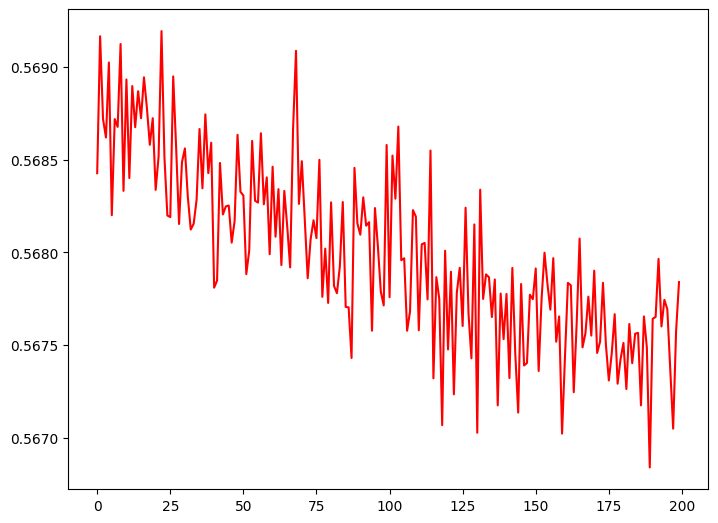

In [13]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
plt.plot(range(len(loss_list_train)), loss_list_train, color= 'red')
# plt.plot(range(len(loss_list_val)), loss_list_val, color = 'blue')


In [14]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for input, target in test_loader:
        input, target = input.to('cuda'), target.to('cuda')
        output = torch.round(model(input))
        all_preds.extend(output.to('cpu'))
        all_labels.extend(target.to('cpu'))

from sklearn.metrics import accuracy_score
print(accuracy_score(all_preds, all_labels))


0.7176382071584679


In [16]:
checkpoint = {'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'accuracy': '72%', 'epochs_run': 1300}
torch.save(checkpoint, './best_parameters.pt')